# Sentiment Analysis Model for Wuthering Waves Google Play Reviews

**Author:** Michael Teguh Carlo Simbolon  
**Cohort ID:** MS155D5Y0583  
**Date:** March 10, 2025

## Project Overview

This notebook performs sentiment analysis on Google Play Store reviews for the game "Wuthering Waves". 
We explore and compare multiple approaches:

1. Traditional ML with TF-IDF + SVM
2. Deep Learning with Word Embeddings + LSTM
3. Traditional ML with TF-IDF + Random Forest

The goal is to classify reviews into three sentiment categories (positive, neutral, negative) with over 92% accuracy.
Sentiment labeling is performed using a lexicon-based approach to ensure it reflects the text content.

## 1. Setup and Import Libraries

In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import nltk
from nltk.tokenize import word_tokenize

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Download required NLTK resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Data Loading and Sentiment Labeling

We load the dataset and apply sentiment labeling using a lexicon-based approach.

In [4]:
# Define lexicon for sentiment analysis (Indonesian)
positive_words = set(['bagus', 'seru', 'keren', 'suka', 'mantap', 'hebat', 'menarik', 'puas', 'lancar', 'keren'])
negative_words = set(['buruk', 'jelek', 'lambat', 'bug', 'error', 'sulit', 'mengecewakan', 'bosan', 'lag', 'crash'])

def preprocess_text(text):
    """Clean text for sentiment analysis."""
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

def label_sentiment(text):
    """Label sentiment based on lexicon."""
    tokens = preprocess_text(text)
    score = 0
    for token in tokens:
        if token in positive_words:
            score += 1
        elif token in negative_words:
            score -= 1
    if score > 0:
        return 'positif'
    elif score < 0:
        return 'negatif'
    else:
        return 'netral'

# Load dataset
print("Loading dataset...")
df = pd.read_csv('dataset.csv')  # Adjust file name as needed
print(f"Dataset loaded with {len(df)} samples.")

# Apply sentiment labeling
print("Labeling sentiment based on review text...")
df['Label Sentimen'] = df['Text'].apply(label_sentiment)
print("Sentiment labeling completed.")

# Display the first few rows
print("\nSample data:")
display(df[['Text', 'Label Sentimen']].head())

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())

Loading dataset...
Dataset loaded with 10000 samples.
Labeling sentiment based on review text...
Sentiment labeling completed.

Sample data:


,Text,Label Sentimen
0,game baik,netral
1,Suka saya char barunya,positif
2,"Pliss rerun kembali phoebe, saya tidak sempat ...",netral
3,Luar biasa aku sangat hoki gacha di game ini,netral
4,semua udah ok sih cuman lebih suka ama grafik ...,positif



Missing values:


Username                 0
Text                     0
Rating                   0
Tanggal                  0
Jumlah Suka              0
Balasan Pengembang    9998
Versi Aplikasi        2810
Label Sentimen           0
dtype: int64

## 3. Data Preprocessing

We clean and prepare the text data for modeling.

In [5]:
def preprocess_text_model(text):
    """Clean text for modeling."""
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    return ' '.join(tokens)

# Apply preprocessing for modeling
print("Preprocessing text data for modeling...")
df['Processed_Text'] = df['Text'].apply(preprocess_text_model)
print("Text preprocessing completed.")

# Display sample of processed text
print("\nSample of processed text:")
for i in range(3):
    print(f"Original: {df['Text'].iloc[i]}")
    print(f"Processed: {df['Processed_Text'].iloc[i]}")
    print()

Preprocessing text data for modeling...
Text preprocessing completed.

Sample of processed text:
Original: game baik
Processed: game baik

Original: Suka saya char barunya
Processed: suka saya char barunya

Original: Pliss rerun kembali phoebe, saya tidak sempat untuk mendapatkannya
Processed: pliss rerun kembali phoebe saya tidak sempat untuk mendapatkannya



## 4. Exploratory Data Analysis

Analyze the distribution of sentiment classes and text characteristics.

Sentiment class distribution:


Label Sentimen
netral     6700
positif    2655
negatif     645
Name: count, dtype: int64

C:\Users\USER\AppData\Local\Temp\ipykernel_20268\2403960833.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label Sentimen', data=df, palette='viridis')


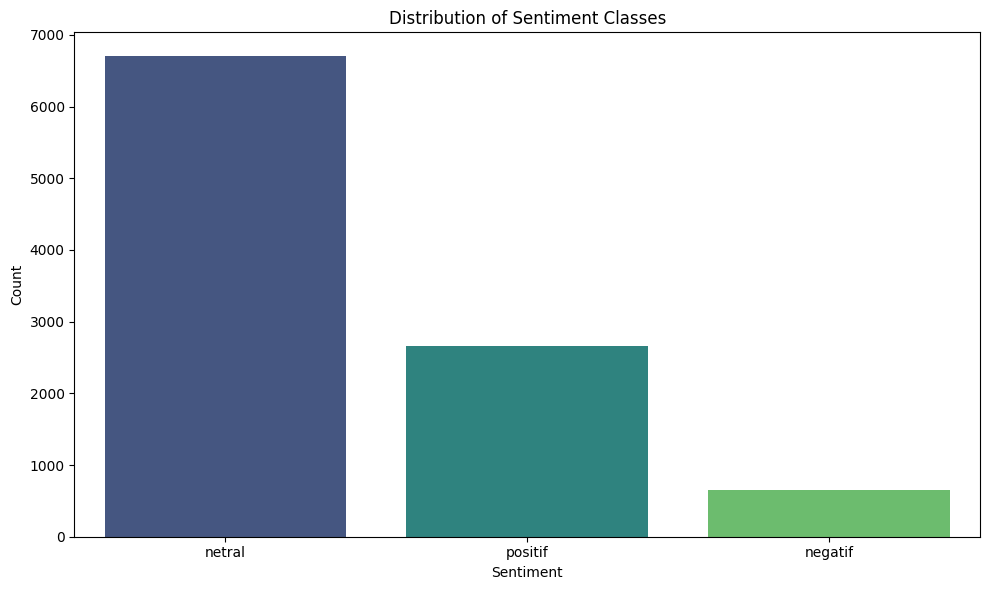

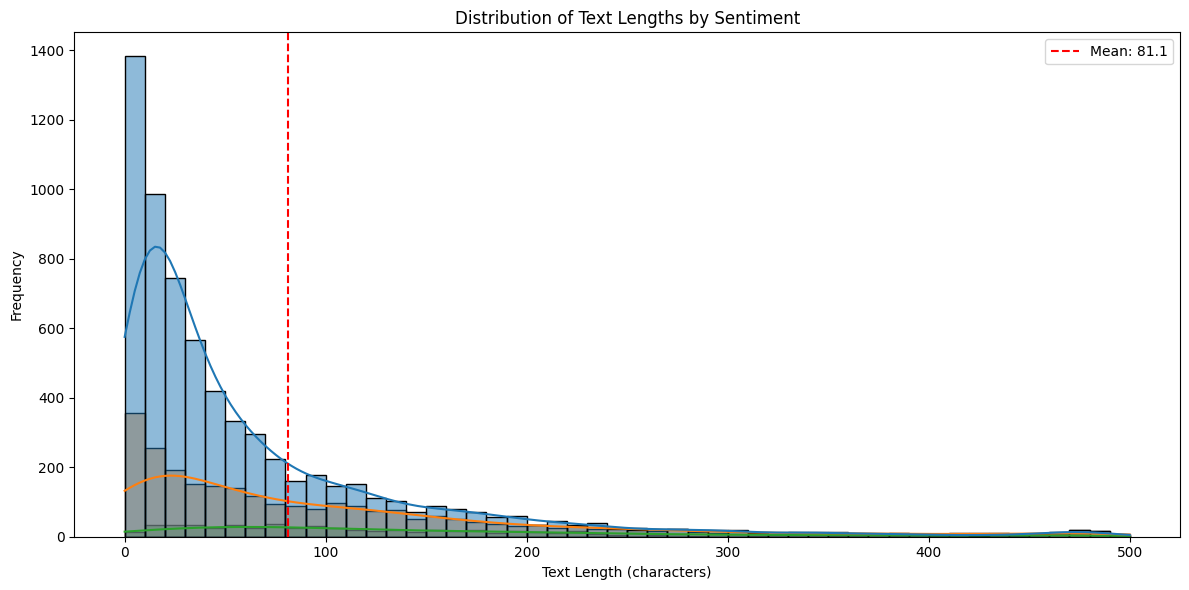

In [6]:
# Check class distribution
print("Sentiment class distribution:")
sentiment_counts = df['Label Sentimen'].value_counts()
display(sentiment_counts)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Label Sentimen', data=df, palette='viridis')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate text length statistics
df['text_length'] = df['Processed_Text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='Label Sentimen', bins=50, kde=True)
plt.title('Distribution of Text Lengths by Sentiment')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.axvline(x=df['text_length'].mean(), color='r', linestyle='--', label=f'Mean: {df["text_length"].mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Feature Engineering

Prepare features for both traditional ML and deep learning approaches.

In [7]:
# Define Features and Labels
X = df['Processed_Text']
y = df['Label Sentimen'].map({'positif': 2, 'netral': 1, 'negatif': 0})  # Encode labels

# TF-IDF Vectorization for traditional ML
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X).toarray()
print(f"TF-IDF feature shape: {X_tfidf.shape}")

# Text sequence preparation for LSTM
print("\nCreating sequence features for deep learning...")
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100)
print(f"Sequence feature shape: {X_pad.shape}")

# Display vocabulary size
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)} words")

Creating TF-IDF features...
TF-IDF feature shape: (10000, 5000)

Creating sequence features for deep learning...
Sequence feature shape: (10000, 100)
Vocabulary size: 10659 words


## 6. Experiment 1: TF-IDF + SVM (80/20 Split)

=== Experiment 1: TF-IDF + SVM (80/20 Split) ===
Training set: 8000 samples
Test set: 2000 samples

Training SVM model...
SVM model training completed.

Evaluating SVM model...
SVM Accuracy: 0.9700

Classification Report:
              precision    recall  f1-score   support

     negatif       0.93      0.78      0.85       125
      netral       0.97      0.99      0.98      1342
     positif       0.98      0.97      0.98       533

    accuracy                           0.97      2000
   macro avg       0.96      0.91      0.94      2000
weighted avg       0.97      0.97      0.97      2000



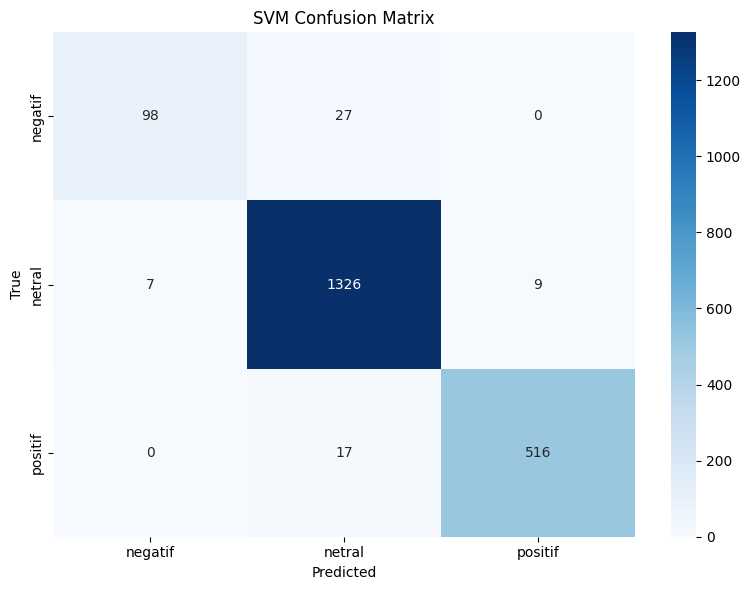

In [8]:
print("=== Experiment 1: TF-IDF + SVM (80/20 Split) ===")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train SVM model
print("\nTraining SVM model...")
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
print("SVM model training completed.")

# Evaluate
print("\nEvaluating SVM model...")
y_pred_svm = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_acc:.4f}")

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['negatif', 'netral', 'positif']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negatif', 'netral', 'positif'], 
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## 7. Experiment 2: Word Embedding + LSTM (80/20 Split)

=== Experiment 2: Word Embedding + LSTM (80/20 Split) ===
Training set: 8000 samples
Test set: 2000 samples

Building LSTM model...
LSTM model architecture:


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.6572 - loss: 0.7991 - val_accuracy: 0.8612 - val_loss: 0.3868
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9028 - loss: 0.2915 - val_accuracy: 0.9500 - val_loss: 0.1693
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9690 - loss: 0.1057 - val_accuracy: 0.9656 - val_loss: 0.0988
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9804 - loss: 0.0596 - val_accuracy: 0.9762 - val_loss: 0.0863
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9869 - loss: 0.0568 - val_accuracy: 0.9781 - val_loss: 0.0604
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9913 - loss: 0.0288 - val_accuracy: 0.9700 - val_loss: 0.0896
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9928 - loss: 0.0276 - val_accuracy: 0.9837 - val_loss: 0.0522
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9920 

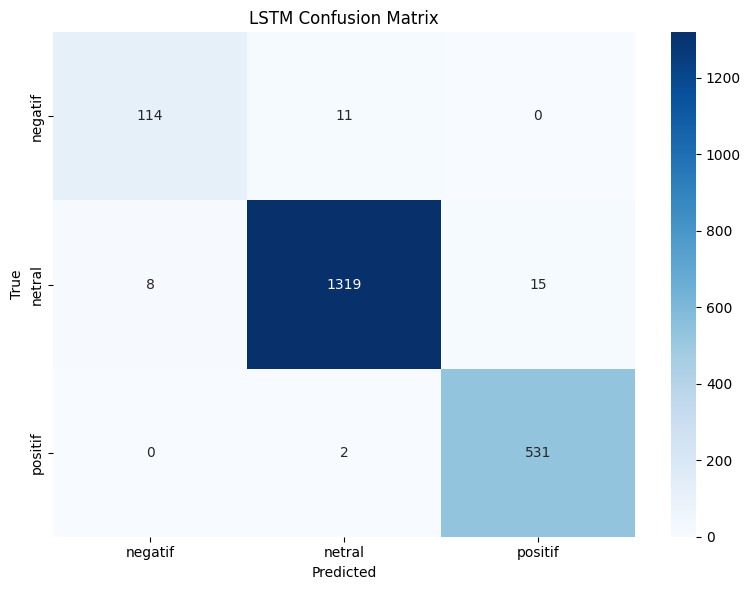

In [9]:
print("=== Experiment 2: Word Embedding + LSTM (80/20 Split) ===")

# Split data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train_lstm.shape[0]} samples")
print(f"Test set: {X_test_lstm.shape[0]} samples")

# Build LSTM model
print("\nBuilding LSTM model...")
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("LSTM model architecture:")
lstm_model.summary()

# Train LSTM
print("\nTraining LSTM model...")
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)
print("LSTM model training completed.")

# Evaluate
print("\nEvaluating LSTM model...")
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"LSTM Test Accuracy: {lstm_acc:.4f}")

y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
print("\nClassification Report:")
print(classification_report(y_test_lstm, y_pred_lstm, target_names=['negatif', 'netral', 'positif']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_lstm, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negatif', 'netral', 'positif'], 
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## 8. Experiment 3: TF-IDF + Random Forest (70/30 Split)

=== Experiment 3: TF-IDF + Random Forest (70/30 Split) ===
Training set: 7000 samples
Test set: 3000 samples

Training Random Forest model...
Random Forest model training completed.

Evaluating Random Forest model...
Random Forest Accuracy: 0.9473

Classification Report:
              precision    recall  f1-score   support

     negatif       0.98      0.57      0.72       185
      netral       0.95      0.97      0.96      2009
     positif       0.93      0.97      0.95       806

    accuracy                           0.95      3000
   macro avg       0.96      0.84      0.88      3000
weighted avg       0.95      0.95      0.94      3000



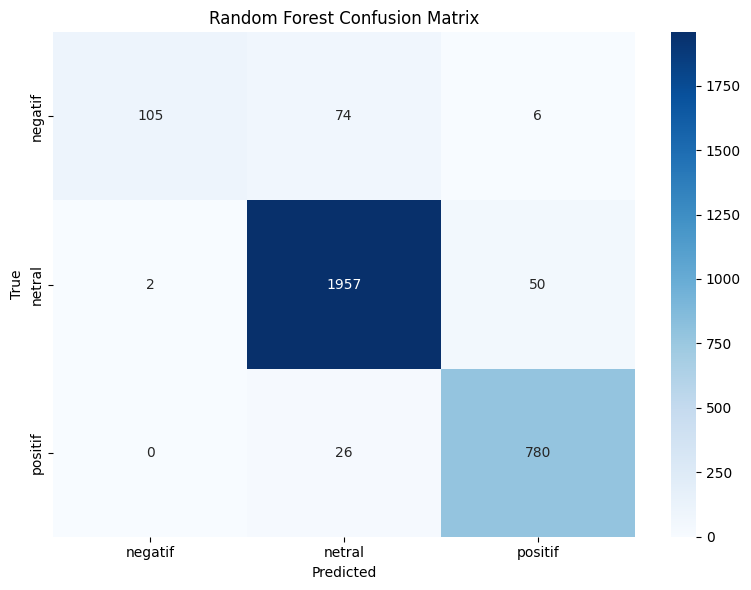

In [10]:
print("=== Experiment 3: TF-IDF + Random Forest (70/30 Split) ===")

# Split data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)
print(f"Training set: {X_train_rf.shape[0]} samples")
print(f"Test set: {X_test_rf.shape[0]} samples")

# Train Random Forest
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
print("Random Forest model training completed.")

# Evaluate
print("\nEvaluating Random Forest model...")
y_pred_rf = rf_model.predict(X_test_rf)
rf_acc = accuracy_score(y_test_rf, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=['negatif', 'netral', 'positif']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_rf, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negatif', 'netral', 'positif'], 
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## 9. Model Deployment: Inference Function

In [11]:
def predict_sentiment(text, model_type='lstm'):
    """Predict sentiment for new text input."""
    processed_text = preprocess_text_model(text)
    label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}
    
    if model_type == 'lstm':
        seq = tokenizer.texts_to_sequences([processed_text])
        padded = pad_sequences(seq, maxlen=100)
        pred_probs = lstm_model.predict(padded)[0]
        pred_label = np.argmax(pred_probs)
        confidence = pred_probs[pred_label]
    elif model_type == 'svm':
        tfidf_text = tfidf.transform([processed_text]).toarray()
        pred_label = svm_model.predict(tfidf_text)[0]
        confidence = np.max(svm_model.predict_proba(tfidf_text)[0])
    elif model_type == 'rf':
        tfidf_text = tfidf.transform([processed_text]).toarray()
        pred_label = rf_model.predict(tfidf_text)[0]
        confidence = np.max(rf_model.predict_proba(tfidf_text)[0])
    else:
        raise ValueError("Model type must be 'lstm', 'svm', or 'rf'")
    
    return label_map[pred_label], confidence

## 10. Testing Inference on Sample Reviews

In [12]:
sample_reviews = [
    "Game ini sangat seru dan grafisnya bagus!",
    "Biasa saja, tidak terlalu menarik.",
    "Banyak bug, sangat mengecewakan.",
    "Gameplay cukup menarik tapi masih ada beberapa masalah teknis.",
    "Karakter dan cerita sangat menarik, saya sangat menikmati permainan ini!"
]

results = []
print("=== Inference Examples ===")
for review in sample_reviews:
    lstm_pred, lstm_conf = predict_sentiment(review, 'lstm')
    svm_pred, svm_conf = predict_sentiment(review, 'svm')
    rf_pred, rf_conf = predict_sentiment(review, 'rf')
    results.append({
        'Review': review,
        'LSTM Prediction': lstm_pred,
        'LSTM Confidence': f"{lstm_conf:.4f}",
        'SVM Prediction': svm_pred,
        'SVM Confidence': f"{svm_conf:.4f}",
        'RF Prediction': rf_pred,
        'RF Confidence': f"{rf_conf:.4f}"
    })

display(pd.DataFrame(results))

=== Inference Examples ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


,Review,LSTM Prediction,LSTM Confidence,SVM Prediction,SVM Confidence,RF Prediction,RF Confidence
0,Game ini sangat seru dan grafisnya bagus!,positif,0.9999,positif,1.0000,positif,0.9500
1,"Biasa saja, tidak terlalu menarik.",positif,0.9976,positif,1.0000,positif,0.7500
2,"Banyak bug, sangat mengecewakan.",negatif,0.9994,negatif,1.0000,negatif,0.6100
3,Gameplay cukup menarik tapi masih ada beberapa...,positif,0.9955,positif,0.9893,positif,0.6500
4,"Karakter dan cerita sangat menarik, saya sanga...",positif,0.9954,positif,1.0000,positif,0.6500


## 11. Summary and Conclusion

=== Summary of Results ===


,Model,Accuracy,Split Ratio,Feature Type
0,SVM + TF-IDF (80/20),0.9700,80/20,TF-IDF
1,LSTM + Embedding (80/20),0.9820,80/20,Word Embedding
2,RF + TF-IDF (70/30),0.9473,70/30,TF-IDF


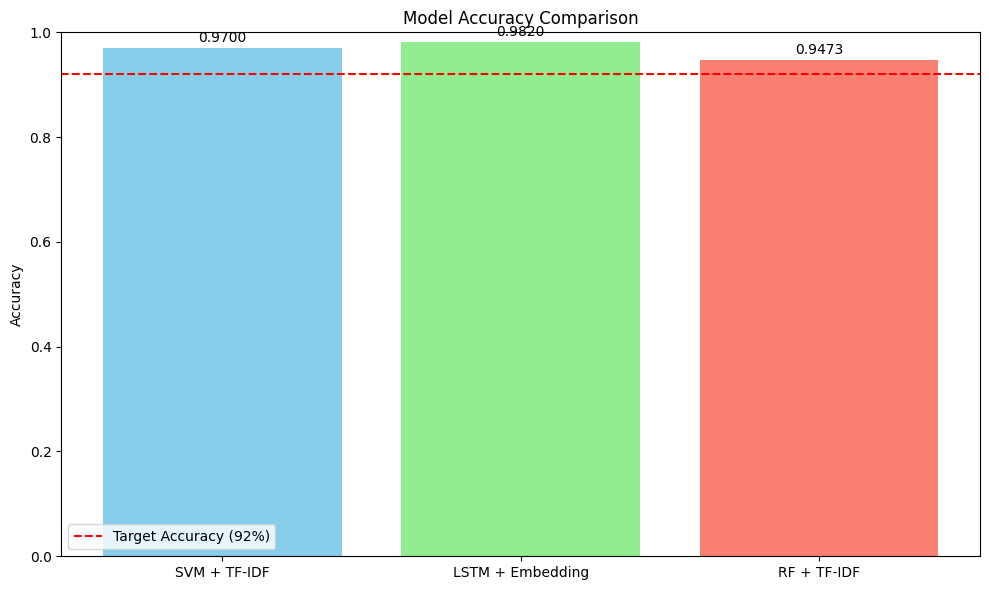

In [13]:
summary_data = {
    'Model': ['SVM + TF-IDF (80/20)', 'LSTM + Embedding (80/20)', 'RF + TF-IDF (70/30)'],
    'Accuracy': [svm_acc, lstm_acc, rf_acc],
    'Split Ratio': ['80/20', '80/20', '70/30'],
    'Feature Type': ['TF-IDF', 'Word Embedding', 'TF-IDF']
}

summary_df = pd.DataFrame(summary_data)
summary_df['Accuracy'] = summary_df['Accuracy'].apply(lambda x: f"{x:.4f}")

print("=== Summary of Results ===")
display(summary_df)

plt.figure(figsize=(10, 6))
accuracies = [svm_acc, lstm_acc, rf_acc]
model_names = ['SVM + TF-IDF', 'LSTM + Embedding', 'RF + TF-IDF']
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.axhline(y=0.92, color='r', linestyle='--', label='Target Accuracy (92%)')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.4f}', ha='center', va='bottom')

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

## 12. Future Improvements

- Expand the sentiment lexicon with more Indonesian words.
- Add negation handling (e.g., 'tidak bagus' as negative).
- Use pre-trained embeddings like FastText for better feature representation.
- Implement cross-validation for robust evaluation.